# Evaluating Factual Consistency in Summarization

**TL;DR:**  
This notebook provides a framework for evaluating factual consistency in summarization models and scaling this process with LLMs. You'll learn how to:  

- Load and preprocess a dataset containing source texts, correct summaries, and distractor (incorrect) summaries.  
- Annotate summaries for factual consistency using binary labels (pass/fail) and calculate metrics like accuracy, precision, and recall.  
- Identify common failure modes in incorrect summaries to better understand model behavior.  
- Train an LLM as a judge to evaluate summaries based on human annotations, providing scalability for larger datasets.  
- Monitor LLM judgments over time by validating against human-labeled samples to ensure alignment and consistency.  

This end-to-end approach combines human and LLM-based evaluations to iteratively improve summary generation workflows and build reliable evaluation systems.  

## Loading the Factual Consistency Dataset

We'll start by loading our dataset from Hugging Face (r-three/fib). This dataset contains:
- Source texts that were summarized
- Paired summaries (one correct, one incorrect)
- Ground truth labels
- Information about distractor generation models

Let's load and examine our data structure:

In [1]:
import pandas as pd

df = pd.read_json("hf://datasets/r-three/fib/test.jsonl", lines=True)

In [7]:
df['list_choices'][0]

[" A new service on the Isle of Wight's chain ferry has been launched following a complaint from a resident.",
 'Passengers using a chain ferry have been warned crossing times will be longer because of new safety measures.']

In [9]:
df.head()

,id,input,correct_choice,list_choices,lbl,distractor_model,dataset
0,32168497,Vehicles and pedestrians will now embark and d...,Passengers using a chain ferry have been warne...,[ A new service on the Isle of Wight's chain f...,1,bart-base,xsum
1,29610109,If you leave your mobile phone somewhere do yo...,"Do you ever feel lonely, stressed or jealous w...","[ You may be worried about your health, but wh...",1,bart-base,xsum
2,38018439,"Speaking on TV, Maria Zakharova said Jews had ...",A spokeswoman on Russian TV has said Jewish pe...,[ The Russian foreign minister has said she ha...,1,bart-base,xsum
3,32790804,"A report by the organisation suggests men, wom...",Egyptian security forces are using sexual viol...,[ Egyptian police are systematically abusing d...,1,bart-base,xsum
4,36437856,Police in Australia and Europe were aware of a...,One word and a freckle indirectly led to Huckl...,[One word and a freckle indirectly led to Huck...,0,bart-base,xsum


## Data Structure Overview

Notice in the sample above:
- Each row contains an input text and multiple summary choices
- The `correct_choice` column indicates the factually consistent summary
- The `list_choices` contains alternative summaries, including distractors
- We'll transform this into a format suitable for annotation

## Preparing for Annotation

We'll now:
1. Create unique IDs for each summary option
2. Pair each input with individual summaries
3. Structure the data for human evaluation

In [10]:
import pandas as pd

# Load the dataset
df = pd.read_json("hf://datasets/r-three/fib/test.jsonl", lines=True)

# Create an empty list to store the new rows
rows = []

# Iterate through each row in the dataset
for _, row in df.iterrows():
    input_text = row["input"]
    list_choices = row["list_choices"]

    # Add each choice from list_choices as a separate row
    for i, choice in enumerate(list_choices):
        rows.append({
            "id": f"{row['id']}_choice_{i}",
            "input": input_text,
            "candidate_summary": choice,
        })

# Create the new DataFrame
expanded_df = pd.DataFrame(rows)

# Save the dataset to a CSV for annotation
expanded_df.to_csv("data/factual_consistency_dataset.csv", index=False)

print(expanded_df.head())

                  id                                              input  \
0  32168497_choice_0  Vehicles and pedestrians will now embark and d...   
1  32168497_choice_1  Vehicles and pedestrians will now embark and d...   
2  29610109_choice_0  If you leave your mobile phone somewhere do yo...   
3  29610109_choice_1  If you leave your mobile phone somewhere do yo...   
4  38018439_choice_0  Speaking on TV, Maria Zakharova said Jews had ...   

                                   candidate_summary  
0   A new service on the Isle of Wight's chain fe...  
1  Passengers using a chain ferry have been warne...  
2   You may be worried about your health, but wha...  
3  Do you ever feel lonely, stressed or jealous w...  
4   The Russian foreign minister has said she has...  


In [11]:
expanded_df.head()

,id,input,candidate_summary
0,32168497_choice_0,Vehicles and pedestrians will now embark and d...,A new service on the Isle of Wight's chain fe...
1,32168497_choice_1,Vehicles and pedestrians will now embark and d...,Passengers using a chain ferry have been warne...
2,29610109_choice_0,If you leave your mobile phone somewhere do yo...,"You may be worried about your health, but wha..."
3,29610109_choice_1,If you leave your mobile phone somewhere do yo...,"Do you ever feel lonely, stressed or jealous w..."
4,38018439_choice_0,"Speaking on TV, Maria Zakharova said Jews had ...",The Russian foreign minister has said she has...


## Exporting Data for Manual Annotation

Before we can evaluate performance, we need human annotations. We'll:
1. Export our prepared data to a CSV file
2. Open it in a spreadsheet tool (Excel, Google Sheets, etc.)
3. Manually assess each summary's factual consistency
4. Save the annotated file for later import

The code above handles the export.

## Merging Annotations with Ground Truth

Now that we have our manual annotations, we need to:
1. Load the annotated CSV file back into our notebook
2. Merge it with our original dataset to compare against ground truth
3. Ensure our IDs and data align correctly

The merging code below combines:
- Our manual annotations (human assessment)
- Original ground truth labels
- Source texts and summaries

## Calculating Evaluation Metrics

With our annotations complete, we can now evaluate performance. We'll calculate:
- Accuracy: Overall correctness of our judgments
- Precision: Accuracy of our "factually consistent" labels
- Recall: How well we identify truly consistent summaries
- Confusion matrix to understand error patterns

Let's compute these metrics:

In [12]:
df_an = pd.read_csv('data/factual_consistency_dataset_annotated.csv')
df_an.head()

,id,input,candidate_summary,human assessment
0,32168497_choice_0,Vehicles and pedestrians will now embark and d...,A new service on the Isle of Wight's chain fer...,0.0
1,32168497_choice_1,Vehicles and pedestrians will now embark and d...,Passengers using a chain ferry have been warne...,1.0
2,29610109_choice_0,If you leave your mobile phone somewhere do yo...,"You may be worried about your health, but wha...",0.0
3,29610109_choice_1,If you leave your mobile phone somewhere do yo...,"Do you ever feel lonely, stressed or jealous w...",1.0
4,38018439_choice_0,"Speaking on TV, Maria Zakharova said Jews had ...",The Russian foreign minister has said she has...,0.0


In [13]:
df_an['base_id'] = df_an['id'].str.extract(r'^(\d+)_choice')
df_an.head()

,id,input,candidate_summary,human assessment,base_id
0,32168497_choice_0,Vehicles and pedestrians will now embark and d...,A new service on the Isle of Wight's chain fer...,0.0,32168497
1,32168497_choice_1,Vehicles and pedestrians will now embark and d...,Passengers using a chain ferry have been warne...,1.0,32168497
2,29610109_choice_0,If you leave your mobile phone somewhere do yo...,"You may be worried about your health, but wha...",0.0,29610109
3,29610109_choice_1,If you leave your mobile phone somewhere do yo...,"Do you ever feel lonely, stressed or jealous w...",1.0,29610109
4,38018439_choice_0,"Speaking on TV, Maria Zakharova said Jews had ...",The Russian foreign minister has said she has...,0.0,38018439


In [14]:
# 1. First merge annotated data with ground truth
comparison = df_an.merge(
    df[['id', 'input', 'correct_choice']].drop_duplicates(subset=['id']),
    left_on='base_id',
    right_on='id',
    suffixes=('_annotated', '_original')
)

# 2. Get rows where human said "yes this is correct" (human assessment = 1)
human_yes = comparison[comparison['human assessment'] == 1.0]

# 3. Check if for these rows, the candidate_summary matches correct_choice
correct = (human_yes['candidate_summary'] == human_yes['correct_choice'])


In [22]:
comparison.head()

,id_annotated,input_annotated,candidate_summary,human assessment,base_id,id_original,input_original,correct_choice
0,32168497_choice_0,Vehicles and pedestrians will now embark and d...,A new service on the Isle of Wight's chain fer...,0.0,32168497,32168497,Vehicles and pedestrians will now embark and d...,Passengers using a chain ferry have been warne...
1,32168497_choice_1,Vehicles and pedestrians will now embark and d...,Passengers using a chain ferry have been warne...,1.0,32168497,32168497,Vehicles and pedestrians will now embark and d...,Passengers using a chain ferry have been warne...
2,29610109_choice_0,If you leave your mobile phone somewhere do yo...,"You may be worried about your health, but wha...",0.0,29610109,29610109,If you leave your mobile phone somewhere do yo...,"Do you ever feel lonely, stressed or jealous w..."
3,29610109_choice_1,If you leave your mobile phone somewhere do yo...,"Do you ever feel lonely, stressed or jealous w...",1.0,29610109,29610109,If you leave your mobile phone somewhere do yo...,"Do you ever feel lonely, stressed or jealous w..."
4,38018439_choice_0,"Speaking on TV, Maria Zakharova said Jews had ...",The Russian foreign minister has said she has...,0.0,38018439,38018439,"Speaking on TV, Maria Zakharova said Jews had ...",A spokeswoman on Russian TV has said Jewish pe...


In [15]:
# Create confusion matrix from our comparison data
human_yes = comparison[comparison['human assessment'] == 1.0]
human_no = comparison[comparison['human assessment'] == 0.0]

# True Positives: Human said yes and it was correct
TP = sum((human_yes['candidate_summary'] == human_yes['correct_choice']))

# False Positives: Human said yes but it was incorrect 
FP = sum((human_yes['candidate_summary'] != human_yes['correct_choice']))

# True Negatives: Human said no and it was incorrect
TN = sum((human_no['candidate_summary'] != human_no['correct_choice']))

# False Negatives: Human said no but it was correct
FN = sum((human_no['candidate_summary'] == human_no['correct_choice']))

print(f"""Confusion Matrix:
              Actual Correct | Actual Incorrect
Predicted Yes:      {TP}     |        {FP}
Predicted No:       {FN}     |        {TN}
""")

Confusion Matrix:
              Actual Correct | Actual Incorrect
Predicted Yes:      23     |        2
Predicted No:       2     |        23



In [16]:
# Calculate metrics
accuracy = (TP + TN) / (TP + FP + TN + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

# Print results
print(f"\nAccuracy  = {accuracy:.3f}")
print(f"Precision = {precision:.3f}")
print(f"Recall    = {recall:.3f}")


Accuracy  = 0.920
Precision = 0.920
Recall    = 0.920


## Analyzing Classification Errors

Understanding our mistakes is crucial for improvement. We'll examine:
- False Positives: What made us mark incorrect summaries as consistent?
- False Negatives: Why did we miss some consistent summaries?

This analysis will help identify patterns in factual consistency judgment:

In [23]:
# Recreate human_yes and human_no just in case
human_yes = comparison[comparison['human assessment'] == 1.0]
human_no = comparison[comparison['human assessment'] == 0.0]

# False Positives (human said yes, but it was incorrect)
fps = human_yes[human_yes['candidate_summary'] != human_yes['correct_choice']]

# False Negatives (human said no, but it was actually correct)
fns = human_no[human_no['candidate_summary'] == human_no['correct_choice']]

In [25]:
print("False Positives (when you said YES but it was wrong):")
for _, row in fps.iterrows():
    print("\n---")
    print("📝 Input:\n", row['input_annotated'])
    print("\n✅ >>> You said this was correct:\n", row['candidate_summary'])
    print("\n❌ >>> But actually this was correct:\n", row['correct_choice'])

print("\nFalse Negatives (when you said NO but it was correct):")
for _, row in fns.iterrows():
    print("\n---")
    print("📝 Input:\n", row['input_annotated'])
    print("\n🚫 >>> You said this wasn't correct:\n", row['candidate_summary'])
    print("\n✅ >>> But it actually was correct:\n", row['correct_choice'])

False Positives (when you said YES but it was wrong):

---
📝 Input:
 Police in Australia and Europe were aware of a paedophile site called the Love Zone hidden in the so-called dark web.
It was protected by passwords, encryption and specialist software. Users were totally anonymous.
The images and videos there were particularly disturbing - showing the abuse of babies and very young children.
Members had to post increasingly graphic material to remain on the site. There were tens of thousands of accounts.
Officers with Task Force Argos in Australia knew the creator of the site used an unusual greeting - the word "hiyas".
After exhaustively trawling chatrooms and forums in the open internet, they found a Facebook page of a man who used the same greeting.
Although the Facebook page was fake, they identified a picture of a vehicle and that led them to a man called Shannon McCoole - a childcare worker in Adelaide.
When officers went through his door, he was actually online running the site

# Summary and Key Findings

Our analysis shows:
- Overall accuracy of ~92%
- Symmetrical confusion matrix (23|2|2|23) due to binary choice structure
- Clear patterns in the types of factual consistency errors

Key takeaways:
- Binary classification provides clear evaluation structure
- Paired summaries help control for length and style
- Error analysis reveals specific patterns in consistency judgment

## In which we generate summaries using an LLM


In [18]:
import pandas as pd

df = pd.read_json("hf://datasets/r-three/fib/test.jsonl", lines=True)

In [19]:
df.head()

,id,input,correct_choice,list_choices,lbl,distractor_model,dataset
0,32168497,Vehicles and pedestrians will now embark and d...,Passengers using a chain ferry have been warne...,[ A new service on the Isle of Wight's chain f...,1,bart-base,xsum
1,29610109,If you leave your mobile phone somewhere do yo...,"Do you ever feel lonely, stressed or jealous w...","[ You may be worried about your health, but wh...",1,bart-base,xsum
2,38018439,"Speaking on TV, Maria Zakharova said Jews had ...",A spokeswoman on Russian TV has said Jewish pe...,[ The Russian foreign minister has said she ha...,1,bart-base,xsum
3,32790804,"A report by the organisation suggests men, wom...",Egyptian security forces are using sexual viol...,[ Egyptian police are systematically abusing d...,1,bart-base,xsum
4,36437856,Police in Australia and Europe were aware of a...,One word and a freckle indirectly led to Huckl...,[One word and a freckle indirectly led to Huck...,0,bart-base,xsum


In [20]:
# Analyze the 'correct_choice' column in the DataFrame

# Calculate basic statistics for length of correct_choice summaries
avg_length_words = df["correct_choice"].apply(lambda x: len(x.split())).mean()
avg_length_sentences = df["correct_choice"].apply(lambda x: len(x.split('. '))).mean()
max_length_words = df["correct_choice"].apply(lambda x: len(x.split())).max()
min_length_words = df["correct_choice"].apply(lambda x: len(x.split())).min()

# Sample a few correct_choice entries
sample_summaries = df["correct_choice"].sample(3).tolist()

# Print out the summary statistics
print("Average Length (Words):", avg_length_words)
print("Average Length (Sentences):", avg_length_sentences)
print("Maximum Length (Words):", max_length_words)
print("Minimum Length (Words):", min_length_words)
print("Sample Summaries:", sample_summaries)

Average Length (Words): 19.248113998323554
Average Length (Sentences): 1.3079072366582845
Maximum Length (Words): 59
Minimum Length (Words): 4
Sample Summaries: ['McLeod has said the government is willing to look at the potential of introducing loans for crofters.', 'A college has moved away from providing degrees for students traditionally excluded from academia, students have warned.', 'Confirmation that bodies found in a grave were Disappeared victims Kevin McKee and Seamus Wright is "bittersweet news", the McKee family has said.']


In [ ]:
import time
import google.generativeai as genai
import pandas as pd

# Configure the Gemini API
genai.configure(api_key="XXX")
model = genai.GenerativeModel("gemini-1.5-flash")


# Prompt 1: Focus on brevity
prompt_1 = "Summarize the following text in a single concise sentence. Only include the most critical details that cannot be omitted:\n\n"

# Prompt 2: Focus on nuance and detail
prompt_2 = "Summarize the following text in one or two sentences. Capture both the key points and any important context or nuance that provides clarity:\n\n"


# Function to generate summaries using a specific prompt
def generate_summary(model, prompt, text):
    response = model.generate_content(prompt + text)
    return response.text.strip()

# Prepare storage for results
results = []

# Limit processing to the first 25 rows of your already-loaded df
subset_df = df.head(25)

# Loop through inputs in the subset DataFrame
for i, row in subset_df.iterrows():
    input_text = row["input"]
    row_id = row["id"]
    
    print("\n" + "="*60)
    print(f"Processing row {i + 1} of {len(subset_df)}")
    print("-" * 60)

    # Generate summary for Prompt 1
    print(f"Prompt 1:\n{prompt_1}")
    summary_1 = generate_summary(model, prompt_1, input_text)
    print(f"Input:\n{input_text}")
    print(f"Response:\n{summary_1}")
    print("-" * 60)

    # Append result for Prompt 1
    results.append({
        "id": row_id,
        "input": input_text,
        "prompt": prompt_1.strip(),
        "response": summary_1
    })

    # Generate summary for Prompt 2
    print(f"Prompt 2:\n{prompt_2}")
    summary_2 = generate_summary(model, prompt_2, input_text)
    print(f"Input:\n{input_text}")
    print(f"Response:\n{summary_2}")
    print("-" * 60)

    # Append result for Prompt 2
    results.append({
        "id": row_id,
        "input": input_text,
        "prompt": prompt_2.strip(),
        "response": summary_2
    })

    # Introduce a delay to respect rate limits
    print(f"Waiting 8 seconds to respect rate limits...\n")
    time.sleep(8)

# Convert results to a DataFrame for easier evaluation
results_df = pd.DataFrame(results)

# Save results to CSV for later annotation and analysis
results_df.to_csv("data/generated_summaries_limited.csv", index=False)

print("Summaries generated and saved to 'generated_summaries_limited.csv'")




Processing row 1 of 25
------------------------------------------------------------
Prompt 1:
Summarize the following text in a single concise sentence. Only include the most critical details that cannot be omitted:


Input:
Vehicles and pedestrians will now embark and disembark the Cowes ferry separately following Maritime and Coastguard Agency (MCA) guidance.
Isle of Wight Council said its new procedures were in response to a resident's complaint.
Councillor Shirley Smart said it would "initially result in a slower service".
Originally passengers and vehicles boarded or disembarked the so called "floating bridge" at the same time.
Ms Smart, who is the executive member for economy and tourism, said the council already had measures in place to control how passengers and vehicles left or embarked the chain ferry "in a safe manner".
However, it was "responding" to the MCA's recommendations "following this complaint".
She added: "This may initially result in a slower service while the me

### Human Annotation Criteria

Annotators should evaluate each candidate summary based on the following binary criteria (pass/fail):

1. **Factual Consistency**
   - Does the summary accurately reflect the source text without introducing any false or unsupported information?

2. **Relevance**
   - Does the summary focus on the key points of the source text, avoiding irrelevant details?

3. **Clarity**
   - Is the summary concise, clear, and easy to understand, without unnecessary complexity or ambiguity?

#### Annotation Instructions
- Assign a label of `pass` if the candidate summary meets all three criteria.
- Assign a label of `fail` if the candidate summary fails to meet any one of the criteria.
- Ensure consistency in labeling across similar summaries.

In [26]:
! pip install matplotlib
! pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 22.9 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 39.1 MB/s eta 0:00:00



Prompt Details:
Prompt 1:
  Prompt Text: Summarize the following text in a single concise sentence, focusing only on the most critical details:
  Total Samples: 10
  Pass Rate: 0.50
--------------------------------------------------
Prompt 2:
  Prompt Text: Summarize the following text in one or two sentences. Capture both the key points and any important context or nuance that provides clarity:
  Total Samples: 10
  Pass Rate: 0.50
--------------------------------------------------


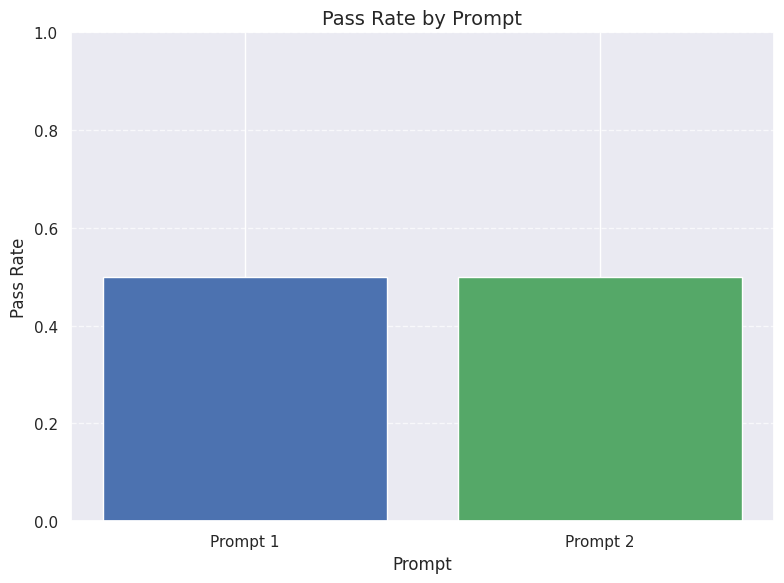

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn for prettier styling
sns.set()

# Path to your labeled data
file_path = "./data/generated_summaries_labeled.csv"

# Load the labeled dataset
df = pd.read_csv(file_path)

# Filter out rows without labels (e.g., NaN in `label`)
df = df.dropna(subset=["label"])

# Convert `label` to integers for analysis
df["label"] = df["label"].astype(int)

# Count pass rates for each prompt directly
pass_rate = df.groupby("prompt")["label"].mean().reset_index()
pass_rate.columns = ["prompt", "pass_rate"]

# Add total counts to the pass_rate DataFrame
pass_rate["total_count"] = df.groupby("prompt")["label"].count().values

# Replace long prompts with simple names
prompt_mapping = {
    "Summarize the following text in a single concise sentence, focusing only on the most critical details:\n\n": "Prompt 1",
    "Summarize the following text in one or two sentences. Capture both the key points and any important context or nuance that provides clarity:\n\n": "Prompt 2"
}
pass_rate["prompt"] = ["Prompt 1", "Prompt 2"]

# Print details to the terminal
print("\nPrompt Details:")
for prompt, row in zip(prompt_mapping.keys(), pass_rate.itertuples(index=False)):
    print(f"{row.prompt}:")
    print(f"  Prompt Text: {prompt.strip()}")
    print(f"  Total Samples: {row.total_count}")
    print(f"  Pass Rate: {row.pass_rate:.2f}")
    print("-" * 50)

# Plot using Matplotlib
plt.figure(figsize=(8, 6))
plt.bar(pass_rate["prompt"], pass_rate["pass_rate"], color=["#4c72b0", "#55a868"])
plt.title("Pass Rate by Prompt", fontsize=14)
plt.ylabel("Pass Rate", fontsize=12)
plt.xlabel("Prompt", fontsize=12)
plt.ylim(0, 1)  # Ensure y-axis is scaled from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for better readability
plt.tight_layout()
plt.show()

### Task: Analyze and Iterate on Prompts

- Review the full text of both prompts.
- Examine inputs and outputs to identify patterns or issues.
- Diagnose why certain outputs were labeled as correct or incorrect.
- Propose a new prompt that combines the strengths of both.
- Iterate to achieve better performance across all inputs.

# Scaling with LLM as a Judge

## Step 1: Define Evaluation Criteria
Clearly state the evaluation criteria for the LLM to act as a judge:  
- **Factual Consistency**: Does the summary accurately reflect the input text?  
- **Relevance**: Does the summary focus on the key points of the input text?  
- **Clarity**: Is the summary concise and easy to understand?  

Ensure these criteria align with the human annotation process to maintain consistency.

## Step 2: Prepare Few-Shot Examples
Create a set of labeled examples for few-shot learning. Include the following:  
- Input text  
- Candidate summary  
- Annotations (pass/fail) with explanations for the decision  

Using the FIB Dataset for Few-Shot Learning:  
- Pair each input with its correct_choice as a pass example  
- Pair input with incorrect list_choices as fail examples, explaining why they fail  

## Step 3: Write Few-Shot Prompt
An example prompt structure:


```
You are an expert evaluator of text summaries. For each summary, evaluate its quality based on:  
1. Factual Consistency: Does the summary accurately reflect the input text?  
2. Relevance: Does the summary focus on the key points of the input text?  
3. Clarity: Is the summary concise and easy to understand?  

Examples:  
Input: "{input_1}"  
Candidate Summary: "{candidate_summary_1}"  
Evaluation: {Pass/Fail with Explanation}  

Input: "{input_2}"  
Candidate Summary: "{candidate_summary_2}"  
Evaluation: {Pass/Fail with Explanation}  

Now, evaluate the following:  
Input: "{new_input}"  
Candidate Summary: "{new_candidate_summary}" 
```

Here's an example of how to create such a prompt:


In [28]:

df = pd.read_json("hf://datasets/r-three/fib/test.jsonl", lines=True)

# Generate few-shot prompt structure with generic reasons
few_shot_prompt = "You are an expert evaluator of text summaries. For each summary, evaluate its quality based on:\n"
few_shot_prompt += "1. Factual Consistency: Does the summary accurately reflect the input text?\n"
few_shot_prompt += "2. Relevance: Does the summary focus on the key points of the input text?\n"
few_shot_prompt += "3. Clarity: Is the summary concise and easy to understand?\n\n"
few_shot_prompt += "Examples:\n\n"

# Adding examples from the dataframe
for index, row in df.iterrows():
    input_text = row['input']
    correct_summary = row['correct_choice']
    incorrect_summaries = [choice for choice in row['list_choices'] if choice != correct_summary]

    # Add correct (pass) example
    few_shot_prompt += f"Input: \"{input_text}\"\n"
    few_shot_prompt += f"Candidate Summary: \"{correct_summary}\"\n"
    few_shot_prompt += "Evaluation: Pass - The summary is factually consistent, relevant, and clear.\n\n"

    # Add one incorrect (fail) example
    if incorrect_summaries:
        incorrect_summary = incorrect_summaries[0]  # Take one incorrect example
        few_shot_prompt += f"Input: \"{input_text}\"\n"
        few_shot_prompt += f"Candidate Summary: \"{incorrect_summary}\"\n"
        few_shot_prompt += (
            "Evaluation: Fail - The summary is factually inconsistent, irrelevant, "
            "or unclear. The exact reason may vary but reflects common patterns.\n\n"
        )

    # Stop after adding 2 examples (1 Pass + 1 Fail)
    if index >= 1:
        break

# Add final task to evaluate a new example
few_shot_prompt += "Now, evaluate the following:\n"
few_shot_prompt += "Input: \"<new_input>\"\n"
few_shot_prompt += "Candidate Summary: \"<new_candidate_summary>\"\n"
few_shot_prompt += "Evaluation:"

# Output the generated prompt
print(few_shot_prompt)

You are an expert evaluator of text summaries. For each summary, evaluate its quality based on:
1. Factual Consistency: Does the summary accurately reflect the input text?
2. Relevance: Does the summary focus on the key points of the input text?
3. Clarity: Is the summary concise and easy to understand?

Examples:

Input: "Vehicles and pedestrians will now embark and disembark the Cowes ferry separately following Maritime and Coastguard Agency (MCA) guidance.
Isle of Wight Council said its new procedures were in response to a resident's complaint.
Councillor Shirley Smart said it would "initially result in a slower service".
Originally passengers and vehicles boarded or disembarked the so called "floating bridge" at the same time.
Ms Smart, who is the executive member for economy and tourism, said the council already had measures in place to control how passengers and vehicles left or embarked the chain ferry "in a safe manner".
However, it was "responding" to the MCA's recommendations


## Step 4: Generate LLM Judgments
- Use the prompt to evaluate new summaries in the dataset  
- Call the LLM API with the few-shot prompt for each candidate summary  
- Collect outputs, including the pass/fail label and reasoning  

## Step 5: Compare LLM Judgments with Human Annotations
Calculate metrics to evaluate LLM performance:  
- **Agreement Rate**: Percentage of LLM judgments that match human annotations  
- **Precision, Recall, F1-Score**: Measure the LLM’s ability to correctly identify pass and fail cases  

Analyze discrepancies between LLM and human judgments to identify areas for improvement  

## Step 6: Automate Scalable Evaluation
- Use the trained LLM as a scalable judge to evaluate large datasets  
- Set up a pipeline to periodically validate LLM judgments against human-labeled samples  
- Track metrics (e.g., agreement rate, error rates) over time to monitor performance  

## Step 7: Monitor and Iterate
- Periodically retrain the LLM with updated few-shot examples based on new human annotations  
- Incorporate feedback from error analysis to refine prompts or evaluation criteria

# Homework Assignment

Recall that the app we’re building generates emails based on data extracted from LinkedIn profiles in structured output format. For this homework, you’ll take the concepts we’ve covered in this class and apply them to this specific task.

## Instructions

1. **Think About Dimensions of Interest**  
   - When extracting structured data from LinkedIn profiles, what specific fields (dimensions) are you most interested in?  
     Examples might include:
     - Name
     - Current Job
     - Top Skills
     - Education
   - Consider which fields are most critical for generating accurate and meaningful emails.

2. **Design an Annotation Process**  
   - If you were to evaluate the LLM’s outputs, how would you set up your annotations?  
     - Would you simply annotate using **Pass/Fail**, or would you evaluate specific fields independently (e.g., "Name" is correct, "Current Job" is incorrect)?  
     - What criteria would you use to evaluate each field?

3. **Create a Spreadsheet for Annotation**  
   - Set up a spreadsheet that includes:
     - The input (e.g., LinkedIn profile text).
     - The LLM’s generated structured output.
     - Columns for your annotations, reflecting the dimensions you care about (e.g., "Name Pass/Fail," "Current Job Pass/Fail," "Top Skills Pass/Fail").

4. **Iterate on the Process**  
   - Test your prompt on a sample set of LinkedIn profiles.
   - Identify failure patterns. For example:
     - The prompt might be effective at extracting "Name" and "Current Job" but less effective at "Top Skills."
   - Adjust your process to improve the weak areas.

5. **Reflect on Your Approach**  
   - How does your annotation setup influence how you evaluate the LLM’s performance?  
   - Would a different approach (e.g., more granular or less granular evaluation) lead to better insights?

Apply this entire process to the LinkedIn profile extraction task, and think critically about how to optimize both the prompts and the evaluation setup for your app.